In [242]:
import numpy as np
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from skimage.filters import gaussian, frangi, hessian, meijering, apply_hysteresis_threshold, threshold_otsu, threshold_local
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import joblib
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk
from skimage import img_as_bool
import cv2

In [3]:
mask = None
img = None
manual1 = None

def load_mask(file_name):
    global mask
    mask_path = 'mask/' + file_name.split('.')[0] + '_mask.tif'
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
    else:
        print(f"Mask file {mask_path} does not exist.")
        mask = None
    
def load_image(file_name):
    global img
    image_path = 'images/' + file_name
    if os.path.exists(image_path):
        img = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)
        
    else:
        print(f"Image file {image_path} does not exist.")
        img = None
    
def load_manual(file_name):
    global manual1
    manual_path = 'manual1/' + file_name.split('.')[0] + '.tif'
    if os.path.exists(manual_path):
        manual1 = cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE)
    else:
        print(f"Manual file {manual_path} does not exist.")
        manual1 = None

Dropdown(index=15, options=('01_dr.JPG', '01_g.jpg', '01_h.jpg', '02_dr.JPG', '02_g.jpg', '02_h.jpg', '03_dr.J…

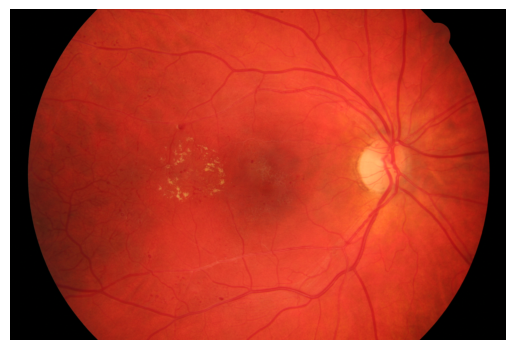

In [ ]:
dir = 'images/'
directory_files = os.listdir(dir)
file_name = directory_files[0]

load_image(file_name)
load_mask(file_name)
load_manual(file_name)

picker = widgets.Dropdown(options=directory_files, disabled=False, )
display(picker)

plt.imshow(img)
plt.axis('off')

def on_change(change):
    clear_output()
    display(picker)
    global img, file_name
    file_name = change.new
    load_image(file_name)
    load_mask(file_name)
    load_manual(file_name)
    plt.imshow(img)
    plt.axis('off')
    


picker.observe(on_change, names='value')


(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

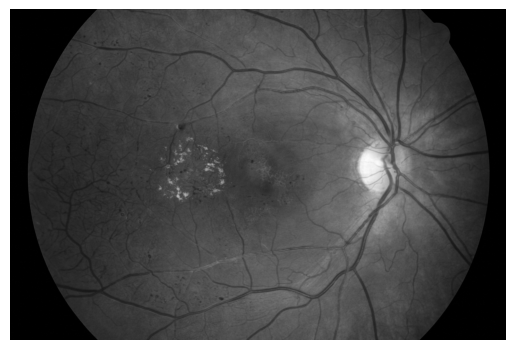

In [5]:
def set_green_channel(image):
    return image[:, :, 1]

green_channel = set_green_channel(img)
plt.imshow(green_channel, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

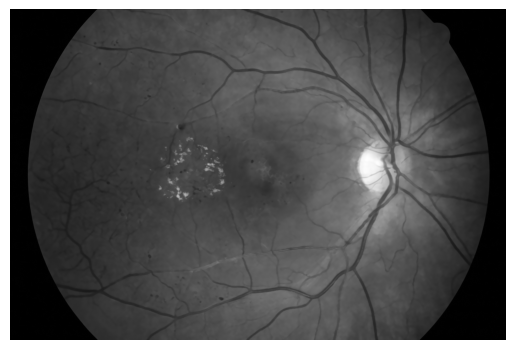

In [179]:
def denoise_image(image):
    resized = cv2.resize(image, (3504, 2336), interpolation=cv2.INTER_AREA)
    normalized = cv2.normalize(resized, None, 0, 255, cv2.NORM_MINMAX)

    noise_removed = cv2.fastNlMeansDenoising(normalized, None, 10, 7, 21)

    return noise_removed

noise_removed = denoise_image(green_channel)
plt.imshow(noise_removed, cmap='gray')
plt.axis('off')

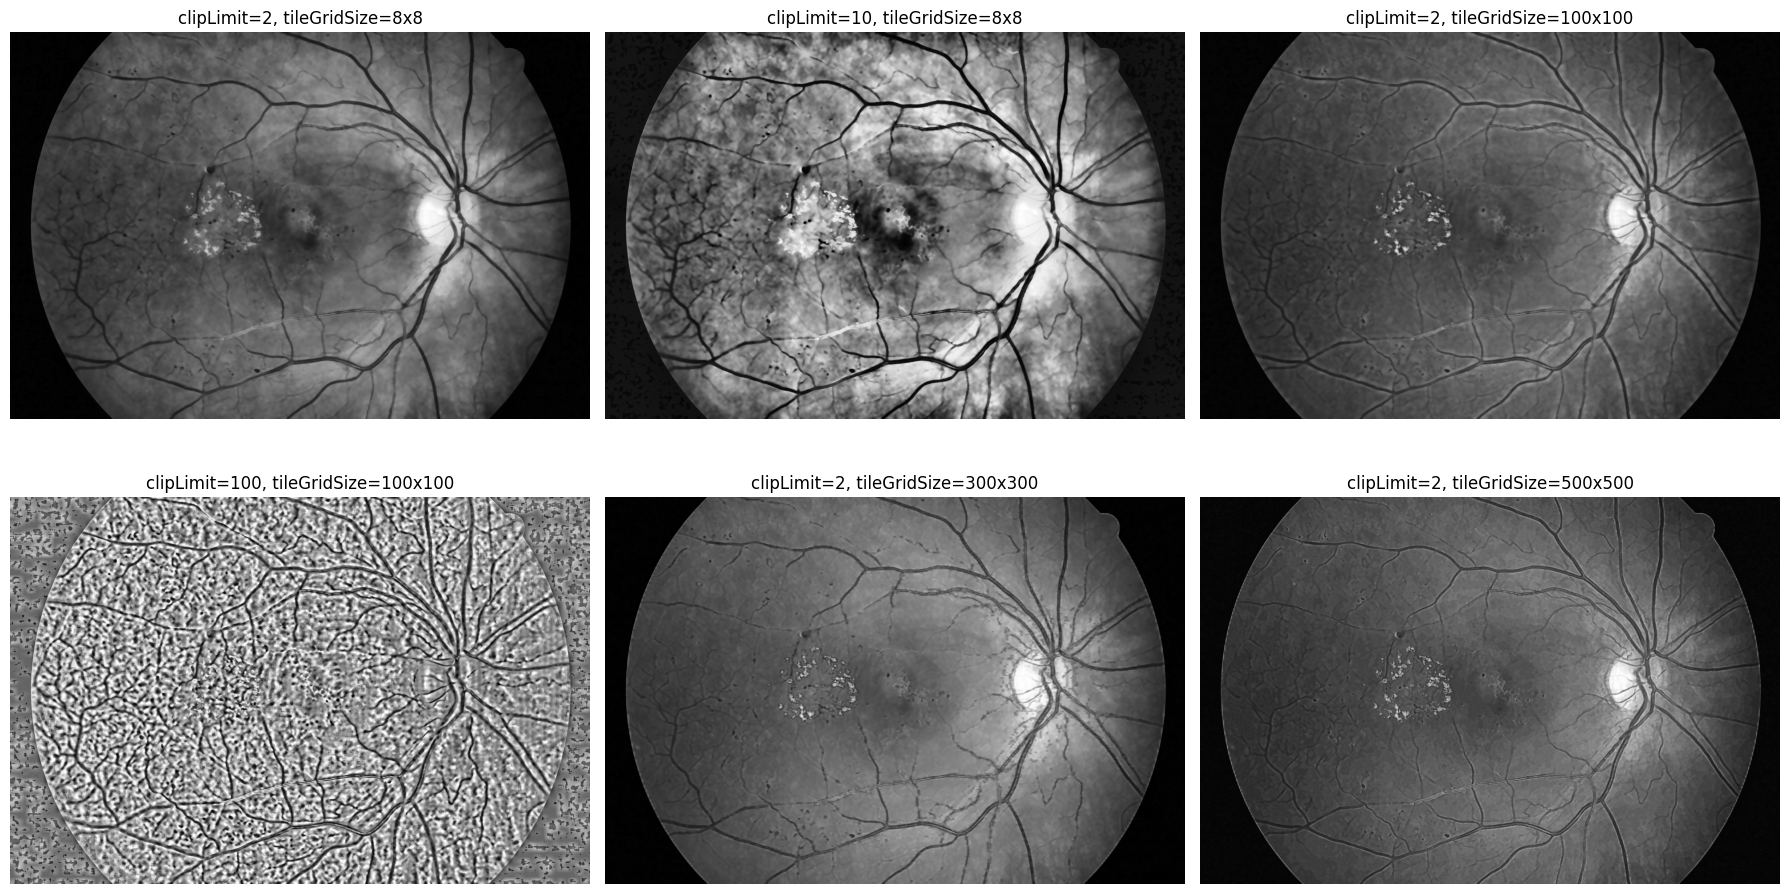

In [181]:
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(300, 300))

    # clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(128, 128))

    equalized = clahe.apply(image.astype(np.uint8))
    return equalized


clahe_params = [
    (2, (8, 8)),
    (10, (8, 8)),
    (2, (100, 100)),
    (100, (100, 100)),
    (2, (300, 300)),
    (2, (500, 500)),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (clip, grid) in enumerate(clahe_params):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
    result = clahe.apply(noise_removed.astype(np.uint8))
    axes[idx].imshow(result, cmap='gray')
    axes[idx].set_title(f'clipLimit={clip}, tileGridSize={grid[0]}x{grid[1]}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

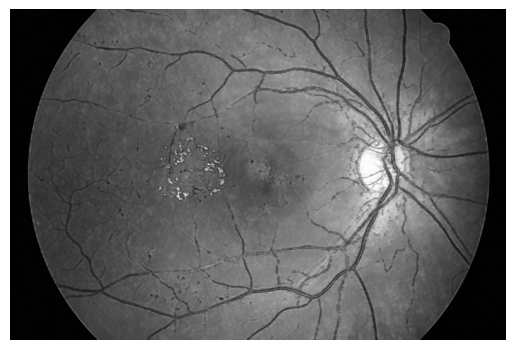

In [182]:
equalized = apply_clahe(noise_removed)
plt.imshow(equalized, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

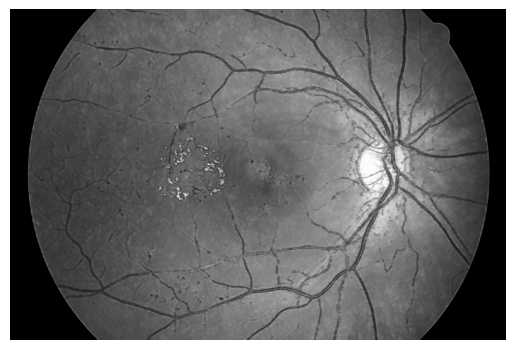

In [183]:
def apply_gausian_blur(image):
    smoothed = cv2.GaussianBlur(image, (9, 9), 0)
    sharpened = cv2.addWeighted(image, 1.5, smoothed, -0.5, 0)
    return cv2.bitwise_and(sharpened, mask)

preprocessed_image = apply_gausian_blur(equalized)

plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')

In [184]:
def preprocess_image(image):
    gc = set_green_channel(image)
    denoise = denoise_image(gc)
    equalized = apply_clahe(denoise)
    blurred = apply_gausian_blur(equalized)
    return blurred

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

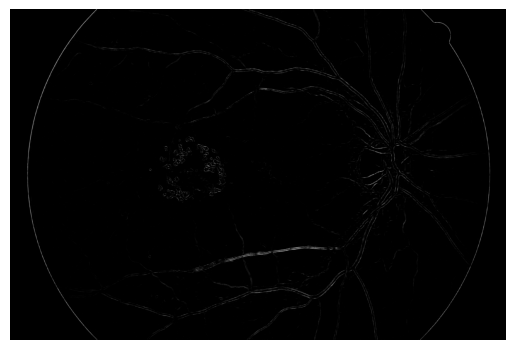

In [201]:
frangi_img = frangi(equalized, sigmas=range(1, 8), alpha=0.1, beta=0.1, gamma=5)
# frangi_img = frangi(equalized, sigmas=(1, 40), alpha=0.5, beta=0.5, gamma=15)

plt.imshow(frangi_img, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

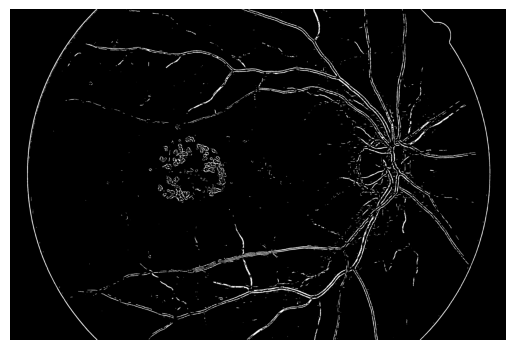

In [204]:
low = 0.025
high = 0.1

img_for_threshold = frangi_img.copy()

hyst = apply_hysteresis_threshold(img_for_threshold, low, high).astype(np.uint8)

# bool_frangi = img_for_threshold > 0.5
# hyst = remove_small_objects(img_as_bool(bool_frangi), min_size=50)

plt.imshow(hyst, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

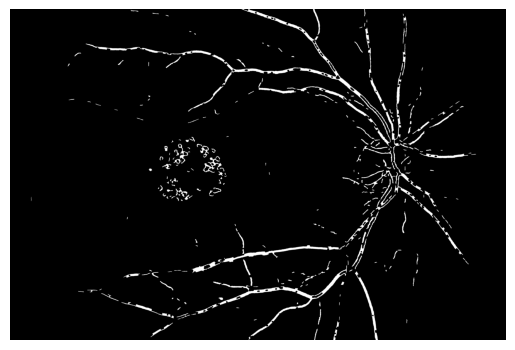

In [251]:
postprococessed_img = cv2.bitwise_and(hyst, hyst, mask=mask)

# postprococessed_img = cv2.morphologyEx(postprococessed_img, cv2.MORPH_ERODE, np.ones((2,2),np.uint8), iterations=1)
# postprococessed_img = cv2.morphologyEx(postprococessed_img, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8), iterations=3)
binary = img_as_bool(postprococessed_img > 0.5)
postprococessed_img = remove_small_objects(binary, min_size=50)
postprococessed_img = remove_small_holes(postprococessed_img, area_threshold=500)
postprococessed_img = closing(postprococessed_img, disk(5))


plt.imshow(postprococessed_img, cmap='gray')
plt.axis('off')

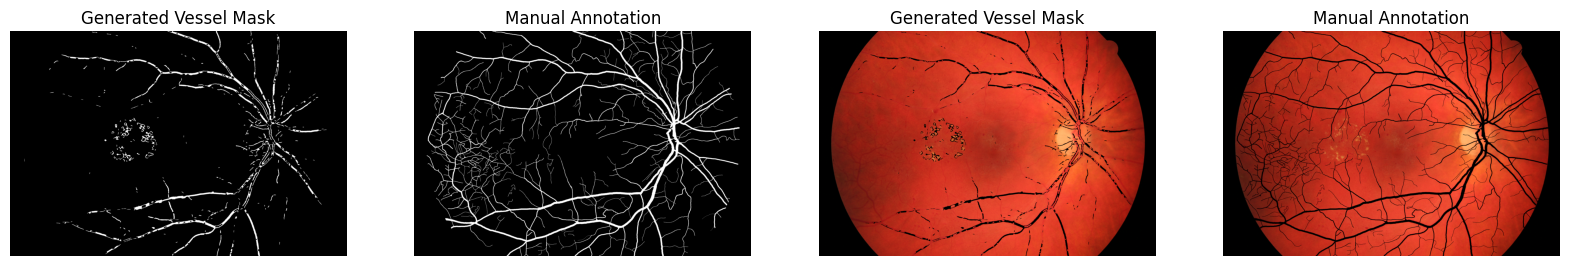

In [252]:
def compare_with_manual(generated_img, manual_img):
    # Ensure both images are the same size
    if generated_img.shape != manual_img.shape:
        manual_resized = cv2.resize(manual_img, (generated_img.shape[1], generated_img.shape[0]))
    else:
        manual_resized = manual_img

    # Normalize images to binary if needed
    gen_bin = (generated_img > 0).astype(np.uint8)
    man_bin = (manual_resized > 0).astype(np.uint8)

    # Show images side by side
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plt.imshow(gen_bin, cmap='gray')
    plt.title('Generated Vessel Mask')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(man_bin, cmap='gray')
    plt.title('Manual Annotation')
    plt.axis('off')

    # Show images
    global img
    inv_gen = 1 - gen_bin
    gen_overlay = cv2.bitwise_and(img, img, mask=inv_gen)
    inv_man = 1 - man_bin
    man_overlay = cv2.bitwise_and(img, img, mask=inv_man)

    plt.subplot(1,4,3)
    plt.imshow(gen_overlay)
    plt.title('Generated Vessel Mask')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(man_overlay)
    plt.title('Manual Annotation')
    plt.axis('off')
    plt.show()


# Example usage:
compare_with_manual(postprococessed_img, manual1)

In [253]:
patch_size = 31

In [254]:
def extract_pixel_patches_with_labels(image, manual, mask, patch_size=patch_size):
    h, w = manual.shape
    pad = patch_size // 2
    padded_image = np.pad(image, pad_width=pad, mode='reflect')

    x_train = []
    y_train = []

    valid_pixels = np.sum(mask != 0)
    print(f"Number of valid pixels in mask: {valid_pixels}")

    # Pre-allocate arrays
    x_train = np.zeros((valid_pixels, patch_size * patch_size), dtype=image.dtype)
    y_train = np.zeros((valid_pixels,), dtype=manual.dtype)

    print(f"Extracting patches of size {patch_size}x{patch_size}...")

    idx = 0
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 0:
                continue

            patch = padded_image[i:i+patch_size, j:j+patch_size]
            x_train[idx, :] = patch.flatten()
            y_train[idx] = manual[i, j]
            idx += 1

    return x_train, y_train

In [256]:
def read_img(image):
    path = 'images/' + image
    return cv2.imread(path, cv2.IMREAD_COLOR_RGB)

def read_mask(image):
    path = 'mask/' + image.split('.')[0] + '_mask.tif'
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def read_manual(image):
    path = 'manual1/' + image.split('.')[0] + '.tif'
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

images_for_training = ['04_dr.JPG', '05_dr.JPG', '04_g.jpg', '05_g.jpg', '04_h.jpg', '05_h.jpg']

all_x = []
all_y = []


for fname in images_for_training:
    img = read_img(fname)
    mask = read_mask(fname)
    manual = read_manual(fname)

    processed_img = preprocess_image(img)
    # processed_img = set_green_channel(img)

    x_train, y_train = extract_pixel_patches_with_labels(processed_img, manual, mask)

    # Under-sample the majority class
    rus = RandomUnderSampler(sampling_strategy={0: 50000, 255: 50000}, random_state=42)
    x_resampled, y_resampled = rus.fit_resample(x_train, y_train)

    print(f"Resampled dataset shape: {Counter(y_resampled)}")

    all_x.append(x_resampled)
    all_y.append(y_resampled)
    
all_x = np.vstack(all_x)
all_y = np.hstack(all_y)

Number of valid pixels in mask: 6913398
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 50000, np.uint8(255): 50000})
Number of valid pixels in mask: 6912374
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 50000, np.uint8(255): 50000})
Number of valid pixels in mask: 6912845
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 50000, np.uint8(255): 50000})
Number of valid pixels in mask: 6913655
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 50000, np.uint8(255): 50000})
Number of valid pixels in mask: 6913012
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 50000, np.uint8(255): 50000})
Number of valid pixels in mask: 6912106
Extracting patches of size 31x31...
Resampled dataset shape: Counter({np.uint8(0): 50000, np.uint8(255): 50000})


In [257]:
X_train, X_test, Y_train, Y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=42, stratify=all_y)

In [258]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

clf.fit(X_train, Y_train)

joblib.dump(clf, 'random_forest_5_6' + '.pkl')

['random_forest_5_6.pkl']

In [259]:
y_pred_train = clf.predict(X_train)

print(classification_report(Y_train, y_pred_train, target_names=["Background", "Vessel"]))
cm = confusion_matrix(Y_train, y_pred_train)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    240000
      Vessel       1.00      1.00      1.00    240000

    accuracy                           1.00    480000
   macro avg       1.00      1.00      1.00    480000
weighted avg       1.00      1.00      1.00    480000

Confusion Matrix:
 [[240000      0]
 [     1 239999]]


In [260]:
y_pred_test = clf.predict(X_test)

print(classification_report(Y_test, y_pred_test, target_names=["Background", "Vessel"]))
cm = confusion_matrix(Y_test, y_pred_test)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

  Background       0.89      0.93      0.91     60000
      Vessel       0.93      0.89      0.91     60000

    accuracy                           0.91    120000
   macro avg       0.91      0.91      0.91    120000
weighted avg       0.91      0.91      0.91    120000

Confusion Matrix:
 [[55882  4118]
 [ 6716 53284]]


In [261]:
def reconstruct_image(predictions, image_shape):
    h, w = image_shape
    reconstructed_img = np.zeros((h, w), dtype=predictions.dtype)
    
    coords = np.argwhere(mask != 0)  # get pixel coords in same order as extraction
    
    for idx, (i, j) in enumerate(coords):
        reconstructed_img[i, j] = predictions[idx]
    
    return reconstructed_img

In [262]:
def extract_pixel_patches(image, mask, patch_size=patch_size):
    h, w = mask.shape
    pad = patch_size // 2
    padded_image = np.pad(image, pad_width=pad, mode='reflect')

    coords = np.argwhere(mask != 0)
    n = len(coords)
    x_test = np.zeros((n, patch_size * patch_size), dtype=image.dtype)

    for idx, (i, j) in enumerate(coords):
        patch = padded_image[i:i+patch_size, j:j+patch_size]
        x_test[idx, :] = patch.flatten()

    return x_test, coords

Extracted 6915024 patches for testing.
Predictions made for 6915024 patches.


(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

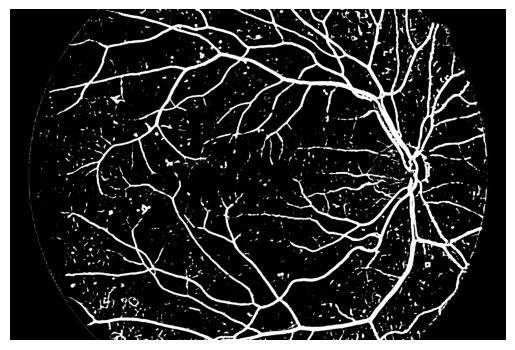

In [263]:
model = joblib.load('random_forest_5_6.pkl')

image_path = 'images/02_dr.JPG'
test_img = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)
test_img = preprocess_image(test_img)

mask = cv2.imread('mask/02_dr_mask.tif', cv2.IMREAD_GRAYSCALE)

x_test, coords = extract_pixel_patches(test_img, mask)
print(f"Extracted {len(x_test)} patches for testing.")

predictions = model.predict(x_test)
print(f"Predictions made for {len(predictions)} patches.")

reconstructed_img = reconstruct_image(predictions, test_img.shape)
plt.imshow(reconstructed_img, cmap='gray')
plt.axis('off')

Extracted 6914369 patches for testing.
Predictions made for 6914369 patches.


(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

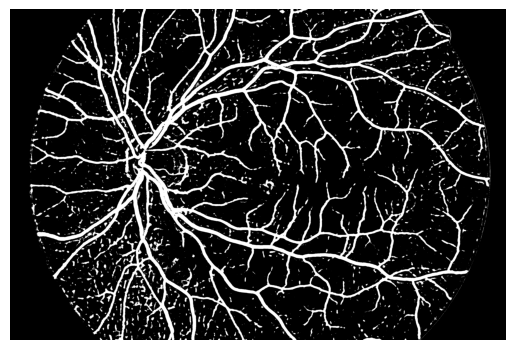

In [264]:
image_path = 'images/02_h.jpg'
test_img = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)
test_img = preprocess_image(test_img)

mask = cv2.imread('mask/02_h_mask.tif', cv2.IMREAD_GRAYSCALE)

x_test, coords = extract_pixel_patches(test_img, mask)
print(f"Extracted {len(x_test)} patches for testing.")

predictions = model.predict(x_test)
print(f"Predictions made for {len(predictions)} patches.")

reconstructed_img = reconstruct_image(predictions, test_img.shape)
plt.imshow(reconstructed_img, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

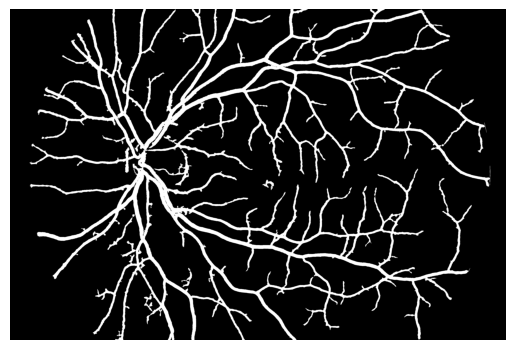

In [277]:
binary = reconstructed_img > 0.5
gg = remove_small_objects(img_as_bool(binary), min_size=2000)

plt.imshow(gg, cmap='gray')
plt.axis('off')

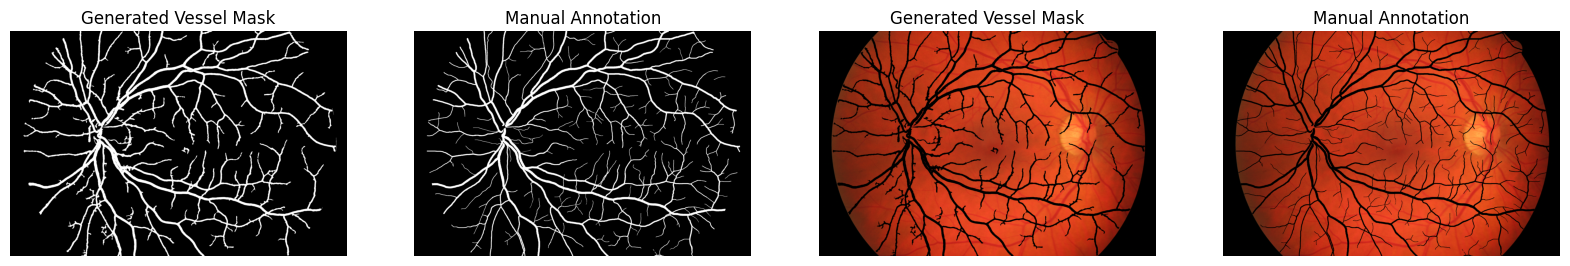

In [278]:
compare_with_manual(gg, cv2.imread('manual1/02_h.tif', cv2.IMREAD_GRAYSCALE))